# SLR data reduction: OTF under the hood

Here we disect the files (one ifproc and four roach spectrometer boards) for an OTF Map observation. Since an observation is typically one short **Cal** followed by a long **Map**, we have 10 files to process for a calibrated observation, in two obsnum's.

The **ifproc** samples at 125 Hz.  The roach boards at 10 Hz (the integration time). Each roach board has 4 beams, their timestamps are staggered, i.e. b0,b1,b2,b3,b0,b1,b2,b3,..... have incremental times at a cadence of about 40 Hz (0.025sec). Note that each board is sampled independantly, thus they needs to be syncd by the software during reduction.

The information what kind of data the telescope is taking is in the **ifproc::BufPos** variable, and takes up four values:
* 0 = "On"
* 1 = "Ref"
* 2 = "Sky"
* 3 = "Hot"

The **Cal** is two short 2.1" bursts of "Hot" and "Sky", with a 2.5" switch time.   The **Map** are many repetitions of "Ref" and "On". For the IRC benchmark data of ~700" there are five "Ref" and four "On". Slewing is about 7-8".  Switching from "Cal" to "Map" is about 14". Each "Ref" is about 10", each "On" about 143"
  
    ObsPgm: <- Cal ->     <------------------- Map ----------------------->
      type:   H s S        s  R s  O  s  R s  O  s  R s  O  s  R s  O  s  R
      time:   2 3 2       14 10 7 143 8 10 7 143 8 10 7 143 8 10 7 143 8 10
      H=hot S=sky R=ref O=on s=slew/switch
    
In this observation, the integration time was 4x143 = 572", the total run was 708", thus an 81% observing efficiency.

The **Header.Dcs.IntegrationTime = 528.4** differs from this timing analysis, which suggested 572".  Is there dead-time between integrations?   If so, then the observing efficiency is 75% for the benchmark.
    

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as pl

import netCDF4
import datetime

from lmtslr.spec import *
from lmtslr.ifproc import *
from lmtslr.viewer.spec_viewer import *

from lmtslr.utils.roach_file_utils import create_roach_list, lookup_roach_files
from lmtslr.utils.ifproc_file_utils import lookup_ifproc_file

from lmtslr.ifproc.ifproc import IFProcData, IFProcCal
from lmtslr.spec.spec import SpecBankCal, SpecBankData

from lmtslr.utils.reader import read_obsnum_ps

testing TKAgg
use() got an unexpected keyword argument 'warn'
testing Agg
use() got an unexpected keyword argument 'warn'
testing GTKAgg
use() got an unexpected keyword argument 'warn'
testing Qt4Agg
use() got an unexpected keyword argument 'warn'
testing WXAgg
use() got an unexpected keyword argument 'warn'


In [2]:
# set root directory for generic LMT data
path = os.environ['DATA_LMT'] 
example = 1
       
# set obsnum for cal (0) and map (1) for one of the two example, or make your own 
if example == 1:
    path = path + '/../IRC_data'   
    obsnum0 = 79447
    obsnum1 = 79448
elif example == 2:
    path = path + '/../M51_data'   
    obsnum0 = 91111
    obsnum1 = 91112
else:
    # M51 data with a CAL, but also embedded CAL in the MAP
    obsnum0 = 92625
    obsnum1 = 92626  


# get the filenames associated with these obsnums                                                                        
iffile0   = lookup_ifproc_file(obsnum0,path=path+'/ifproc')
rofile0,n = lookup_roach_files(obsnum0,path=path+'/spectrometer')

iffile1   = lookup_ifproc_file(obsnum1,path=path+'/ifproc')
rofile1,n = lookup_roach_files(obsnum1,path=path+'/spectrometer')


In [3]:
print(path)
print(iffile0)
print(iffile1)

/home/teuben/LMT/data_lmt/../IRC_data
/home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc
/home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079448_01_0000.nc


In [4]:
def date_obs(date):
    """ convert to ISO """
    return datetime.datetime.fromtimestamp(date).strftime('%Y-%m-%dT%H:%M:%S')
    

In [5]:
def get_ifproc(filename):
    """ get some header info from an ifproc file"""
    
    nc = netCDF4.Dataset(filename)
    
    bufpos = nc.variables['Data.TelescopeBackend.BufPos'][:]
    dates  = nc.variables['Data.TelescopeBackend.TelTime'][:]
    date0   = date_obs(dates[0])
    date1   = date_obs(dates[-1])
    tsky    = dates[-1] - dates[0]
    sname = filename[filename.rfind('/')+1:]
    
    cnt = []
    for b in [0,1,2,3]:
        idx = np.where(bufpos==b)
        cnt.append(len(idx[0]))
    print(sname,date0,date1,int(tsky),cnt)   
    
    nc.close()

In [6]:
def get_roach(filename):
    """ get some roach board info """
    
    nc = netCDF4.Dataset(filename)
    
    dates = nc.variables['Data.Integrate.time'][:]
    date0   = date_obs(dates[0])
    date1   = date_obs(dates[-1])
    tsky    = dates[-1] - dates[0]
    sname   = filename[filename.rfind('/')+1:]
    nsky = len(dates)
    print(sname,date0,date1,int(tsky),nsky)  
    
    nc.close()

In [7]:
get_ifproc(iffile0)
get_ifproc(iffile1)
for f in rofile0:
    get_roach(f)    
for f in rofile1:
    get_roach(f)

ifproc_2018-11-16_079447_00_0001.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 [0, 0, 265, 263]
ifproc_2018-11-16_079448_01_0000.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 685 [57349, 5108, 0, 0]
roach0_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 236
roach1_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 236
roach2_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 7 240
roach3_79447_0_1_IRC+10216_2018-11-16_114830.nc 2018-11-16T06:48:30 2018-11-16T06:48:38 8 244
roach0_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25108
roach1_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25112
roach2_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25140
roach3_79448_1_0_IRC+10216_2018-11-16_114845.nc 2018-11-16T06:48:52 2018-11-16T07:00:18 686 25144


###    Detailed look at time

By plotting the time we can see slewing (for the Map, about 7-8") and switching hot/sky (for the Cal, about 2.5").

In [8]:
def get_dates(filename,varname,varname2=None):
    nc = netCDF4.Dataset(filename)
    var  = nc.variables[varname][:]
    if varname2 != None:
        var2 = nc.variables[varname2][:]
    nc.close()
    if varname2 != None:
        return (var,var2)
    return var

In [9]:
if True:
    # ifproc file contain the bufpos
    (dates0,bp0) = get_dates(iffile0,'Data.TelescopeBackend.TelTime','Data.TelescopeBackend.BufPos')
    (dates1,bp1) = get_dates(iffile1,'Data.TelescopeBackend.TelTime','Data.TelescopeBackend.BufPos')
    time0 = dates0[0]
else:
    # roach files don't have a bufpos, it will be derived later
    dates0 = get_dates(rofile0[0],'Data.Integrate.time')
    dates1 = get_dates(rofile1[0],'Data.Integrate.time') 
    bp0 = -1 * np.ones(len(dates0)) 
    bp1 = -1 * np.ones(len(dates1))
    
dates2 = np.append(dates0,dates1)
bp2 = np.append(bp0,bp1)
    


1542368910.3623033
1542368910.3623033
0.00800013542175293
0.040000200271606445
708.210000038147


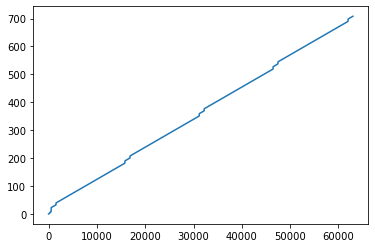

In [10]:
dates = dates2 - dates2[0]
dates = dates2 - time0
pl.plot(range(len(dates)),dates);
print(dates0[0])
print(time0)
print(dates[1]-dates[0])
print(dates[4]-dates[0])
print(dates[-1]-dates[0])

In [11]:
#   find the times where a jump occured
x=dates[1:]-dates[:-1]
idx = np.where(x>0.1)
d = dates[idx]
y=d[1:]-d[:-1]
print(len(dates),len(d))

62985 10


In [12]:
# print out the times of the jumps, and if available, the bufpos
t = 0
n = 1
for i in idx[0]:
    dt = dates[i]-t
    print("%3d %7.2f %7.2f  %6d  %d" % (n,t,dt,i,bp2[i]))
    n = n + 1
    t = dates[i]
    dt = dates[i+1]-t
    print("%3d %7.2f %7.2f  %6d     switch/slew" % (n,t,dt,i+1))
    t = dates[i+1]
    n = n + 1
dt = dates[-1]-t
print("%3d %7.2f %7.2f  %6d  %d" % (n,t,dt,len(dates)-1,bp2[-1]))

  1    0.00    2.62     262  3
  2    2.62    2.49     263     switch/slew
  3    5.11    2.64     527  2
  4    7.75   14.65     528     switch/slew
  5   22.40   10.12    1540  1
  6   32.52    6.75    1541     switch/slew
  7   39.27  142.51   15794  0
  8  181.77    8.11   15795     switch/slew
  9  189.88   10.56   16851  1
 10  200.44    7.12   16852     switch/slew
 11  207.56  143.26   31180  0
 12  350.82    8.33   31181     switch/slew
 13  359.15   10.11   32192  1
 14  369.26    7.21   32193     switch/slew
 15  376.47  142.61   46456  0
 16  519.08    8.28   46457     switch/slew
 17  527.36   10.12   47469  1
 18  537.48    7.28   47470     switch/slew
 19  544.75  144.99   61971  0
 20  689.75    8.35   61972     switch/slew
 21  698.09   10.12   62984  1


# Looking at raw calibration spectra

The short calibration file is in **iffile0**, and we will grab some Hot/Sky calibration spectra from **rofile0[0]**, the first 4 pixels

In [13]:
print(iffile0)
print(rofile0[0])

/home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc
/home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach0/roach0_79447_0_1_IRC+10216_2018-11-16_114830.nc


In [14]:
ICal = IFProcData(iffile0)

2018-11-16T06:48:30 begin /home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc
2018-11-16T06:48:38 end   /home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  10
/home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc does not have map parameters
/home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079447_00_0001.nc does not have bs parameters
get chop
'Data.Msip1mm.BeamChopperActPos'
 no chop


Traceback (most recent call last):
  File "/home/teuben/LMT/lmtoy/SpectralLineReduction/lmtslr/ifproc/ifproc.py", line 570, in __init__
    self.chop = self.nc.variables['Data.Msip1mm.BeamChopperActPos'][:]
KeyError: 'Data.Msip1mm.BeamChopperActPos'


In [15]:
SCal = SpecBankData(rofile0,ICal,pixel_list=[0,1,2,3])

read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach0/roach0_79447_0_1_IRC+10216_2018-11-16_114830.nc     nspec,nchan=236,2048
r:0 inp:0 pix:0 time_offset:-0.030000
r:0 inp:1 pix:1 time_offset:-0.030000
r:0 inp:2 pix:2 time_offset:-0.030000
r:0 inp:3 pix:3 time_offset:-0.030000
read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach1/roach1_79447_0_1_IRC+10216_2018-11-16_114830.nc     nspec,nchan=236,2048
read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach2/roach2_79447_0_1_IRC+10216_2018-11-16_114830.nc     nspec,nchan=240,2048
read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach3/roach3_79447_0_1_IRC+10216_2018-11-16_114830.nc     nspec,nchan=244,2048


During the construction of the SpecBankData the time is used to check which integration belongs to which bufpos. Recall **I** is sampled at 125Hz and **S** at 10 Hz

In [16]:
print(ICal.bufpos)
print(SCal.roach[0].bufpos)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [17]:
SCal.roach[0].hots

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [18]:
SCal.roach[0].skys

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53])

In [19]:
SCal.roach[0].raw_spec.shape


(54, 2048)

In [20]:
sky = SCal.roach[0].raw_spec[SCal.roach[0].skys]
hot = SCal.roach[0].raw_spec[SCal.roach[0].hots]
sky1 = sky.mean(axis=0)
sky2 = sky.std(axis=0)
hot1 = hot.mean(axis=0)
hot2 = hot.std(axis=0)
skyr = sky1/sky2
hotr = hot1/hot2

<ipython-input-20-2e65f7403d2f>:7: RuntimeWarning: invalid value encountered in true_divide
  skyr = sky1/sky2


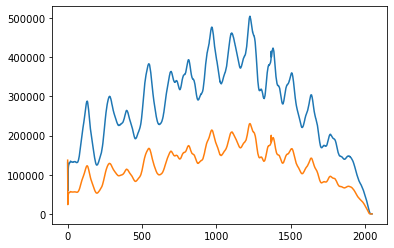

In [21]:
pl.plot(hot1)
pl.plot(sky1);

The intensity units are "arbitrary" uncalibrated, and channel numbers are plotted horizontally. In this case the channels are 1 km/s at 115GHz, for a bandwidth of 800 MHz.


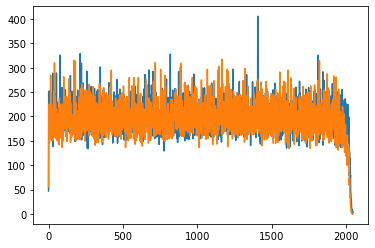

In [22]:
# compute signal to noise ratio
pl.plot(hotr)
pl.plot(skyr);

Now construct the **Tsys** spectrum, but leaving out some edge channels due to low sensitivity

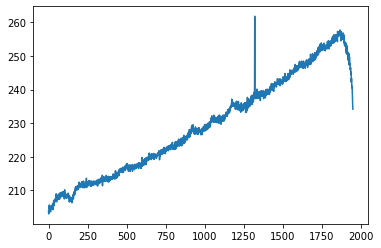

In [23]:
tamb = 280
edge = 50
Tsys = tamb * sky1/(hot1-sky1)
pl.plot(Tsys[edge:-edge]);


# Calibrating a spectrum

Similar to the calibration file, we grab the **I** and **S** for the Map.

In [24]:
IMap = IFProcData(iffile1)

2018-11-16T06:48:52 begin /home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079448_01_0000.nc
2018-11-16T07:00:18 end   /home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079448_01_0000.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  10
Map Parameters: Ra Continuous
HPBW= 16.0 XLength=   400.0 YLength=   400.0 XStep=  1.00                        YStep=  0.70
/home/teuben/LMT/data_lmt/../IRC_data/ifproc/ifproc_2018-11-16_079448_01_0000.nc does not have bs parameters
79448 is a Map observation
get chop
'Data.Msip1mm.BeamChopperActPos'
 no chop


Traceback (most recent call last):
  File "/home/teuben/LMT/lmtoy/SpectralLineReduction/lmtslr/ifproc/ifproc.py", line 570, in __init__
    self.chop = self.nc.variables['Data.Msip1mm.BeamChopperActPos'][:]
KeyError: 'Data.Msip1mm.BeamChopperActPos'


In [25]:
SMap = SpecBankData(rofile1,IMap,pixel_list=[0,1,2,3])

read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach0/roach0_79448_1_0_IRC+10216_2018-11-16_114845.nc     nspec,nchan=25108,2048
r:0 inp:0 pix:0 time_offset:-0.030000
r:0 inp:1 pix:1 time_offset:-0.030000
r:0 inp:2 pix:2 time_offset:-0.030000
r:0 inp:3 pix:3 time_offset:-0.030000
read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach1/roach1_79448_1_0_IRC+10216_2018-11-16_114845.nc     nspec,nchan=25112,2048
read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach2/roach2_79448_1_0_IRC+10216_2018-11-16_114845.nc     nspec,nchan=25140,2048
read_roach /home/teuben/LMT/data_lmt/../IRC_data/spectrometer/roach3/roach3_79448_1_0_IRC+10216_2018-11-16_114845.nc     nspec,nchan=25144,2048


In [26]:
SMap.roach[0].on_ranges

[(102, 1528), (1635, 3068), (3170, 4597), (4700, 6149)]

In [27]:
SMap.roach[0].ref_ranges

[(0, 101), (1529, 1634), (3069, 3169), (4598, 4699), (6150, 6251)]

Thus there are 4 series of On's.  If we take halfway the first row in the 3rd set, we are roughly int the middle of the map, and expect to see a strong signal in this IRC example. We will cheat and just take the Ref from the point before (3169).   The only thing we don't know here is how many rows there are in this section. You have to believe me, there are 10, thus half-way the first row is about 70 points down the line, since there are about 1400 points in an "On" section.

We also don't know which of the 4 pixels in this roach it is..... TBD. But to first order we can ignore that.

<ipython-input-28-95be7b7d23f1>:8: RuntimeWarning: invalid value encountered in true_divide
  Ta = Tsys * (on-ref)/ref


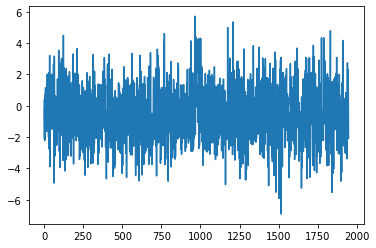

In [28]:
iref = 3169
ion  = iref+70    #  ~140 points along a single X, doing this 10 times
#

ref = SMap.roach[0].raw_spec[iref]
on  = SMap.roach[0].raw_spec[ion]

Ta = Tsys * (on-ref)/ref
pl.plot(Ta[edge:-edge]);

Even in this single 0.1sec integration, there is a signal near the middle of the spectrum. A modest hanning smoothing should bring that out a bit more.

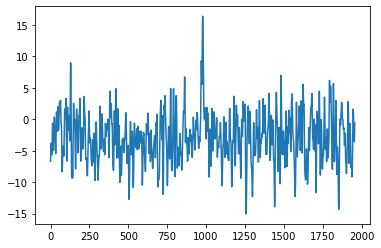

In [29]:
h = np.hanning(11)
Tasm = np.convolve(Ta,h)
pl.plot(Tasm[edge:-edge]);

Each roach board thus produces about 1400 * 4 points, for 4 boards this will be about 22,000 spectra in a 400 x 400" grid. You have to believe me on that one too. These will need to be gridded in a map, and since the FWHM is about 15", there are about 700 independant resolution elements. Thus we have effectively about 30 integrations, or 3sec integration time, per resolution element.

Gridding is beyond the scope of this notebook. In addition, it is computationally more intensive, and the gridder is written in C.